In [1]:
import pandas as pd
from IPython.display import SVG, display
import svgpathtools as pt
import numpy as np
import re
import json
import shutil

This is exactly the same as the original `clickable_map`, but it works on an SVG file which was generated by the former notebook and then manually corrected

In [2]:
inputmap = '20230412_editable_map_test_V2.svg'

In [3]:
viewBox = pt.Document(inputmap).root.attrib['viewBox']

In [4]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='frontier']/svg:path" />
        </groups>
    </xsl:template>

    <!-- indices to merge references -->
    <xsl:template match="svg:path">
        <frontier>
            <d><xsl:value-of select="@d" /></d>
            <id><xsl:value-of select="../@id" /></id>
        </frontier>
    </xsl:template>
    
</xsl:stylesheet>
'''
frontier = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*',)
frontier['path'] = frontier['d'].apply(lambda r: pt.parse_path(r).d())

Next, the actual meet: the paths and lines representing buslines. We'll convert lines t o paths for a more homogenous representation and generally apply `svgpathtools.Path` to retain only absolute coordinates (I did not find out how to effectively use `svgpathtools` own eltree based methods to parse SVG directly):

In [5]:
def split_id_code(dta):
    codes = dta['id'].str.extract('_(\d+)-(\d+)?')
    dta['id'] = codes[0].astype(int)
    dta['line'] = codes[1].astype(int)
    return dta


In [6]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='lines']/svg:g/svg:g/svg:line" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='lines']/svg:g/svg:g/svg:polyline" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='lines']/svg:g/svg:g/svg:polygon" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='lines']/svg:g/svg:g/svg:path" />
        </groups>
    </xsl:template>

    <!-- indices to merge references -->
    <xsl:template match="svg:polyline">
        <ligne>
            <points><xsl:value-of select="@points" /></points>
            <id><xsl:value-of select="../../@id" /></id>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>
    
    <xsl:template match="svg:polygon">
        <ligne>
            <points><xsl:value-of select="@points" /></points>
            <id><xsl:value-of select="ancestor::svg:g[@id!='lines']/@id" /></id>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>
    
    <xsl:template match="svg:line">
        <ligne>
            <d>M <xsl:value-of select="@x1" />,<xsl:value-of select="@y1" /> L <xsl:value-of select="@x2" />,<xsl:value-of select="@y2" /></d>
            <id><xsl:value-of select="ancestor::svg:g[@id!='lines']/@id" /></id>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>
    
    <xsl:template match="svg:path">
        <ligne>
            <d><xsl:value-of select="@d" /></d>
            <id><xsl:value-of select="ancestor::svg:g[@id!='lines']/@id" /></id>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>

    
</xsl:stylesheet>
'''
lines = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*')

lines = split_id_code(lines)

def iter_points(points):
    for point in points.split():
        a, b = re.split(' *, *', point)
        yield float(a) + float(b) * 1j
        

# transform everything to paths
filt = ~lines['d'].isnull()
lines.loc[filt, 'path'] = lines.loc[filt, 'd'].apply(lambda d: pt.parse_path(d).d())
filt = ~lines['points'].isnull()
lines.loc[filt, 'path'] = lines.loc[filt, 'points'].apply(lambda d: pt.polyline(*iter_points(d)).d())
lines = lines.drop(['points', 'd'], axis=1)

# actually, it turns out not to be useful to retain class
lines = lines.drop_duplicates(['id', 'path'])
lines = lines.drop('class', axis=1).sort_values(['id'])

Next we have a bunch of circles representings stops and locations. 

In [7]:
def split_codes_str(dta):
    pos = dta['id'].str.extract('^_(\d+)-([A-Za-zéèëüäöûÉ\-_2]+)(?:_\d+_)?$')
    assert not pos[0].isnull().any()
    dta['id'] = pos[0].fillna(-1).astype(int)
    dta['id_label'] = pos[1]
    return dta

In [8]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stops']//svg:circle" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stops']//svg:path" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stops']//svg:ellipse" />
        </groups>
    </xsl:template>

    <xsl:template match="svg:path">
        <ligne>
            <id><xsl:value-of select="ancestor::svg:g[@id!='stops']/@id" /><xsl:value-of select="@id" /></id>
            <d><xsl:value-of select="@d" /></d>
            <class><xsl:value-of select="@class" /></class>
        </ligne>
    </xsl:template>

    <xsl:template match="svg:circle">
        <stop>
            <id><xsl:value-of select="ancestor::svg:g[@id!='stops']/@id" /></id>
            <cx><xsl:value-of select="@cx" /></cx>
            <cy><xsl:value-of select="@cy" /></cy>
            <rx><xsl:value-of select="@r" /></rx>
            <class><xsl:value-of select="@class" /></class>
            <transform><xsl:value-of select="@transform" /></transform>
        </stop>
    </xsl:template>

    <xsl:template match="svg:ellipse">
        <stop>
            <id><xsl:value-of select="ancestor::svg:g[@id!='stops']/@id" /></id>
            <cx><xsl:value-of select="@cx" /></cx>
            <cy><xsl:value-of select="@cy" /></cy>
            <rx><xsl:value-of select="@rx" /></rx>
            <ry><xsl:value-of select="@ry" /></ry>
            <class><xsl:value-of select="@class" /></class>
            <transform><xsl:value-of select="@transform" /></transform>
        </stop>
    </xsl:template>

    
</xsl:stylesheet>
'''
stop_places = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*')
stop_places = split_codes_str(stop_places)

# convert to path - store coordinates of bbox's center as 'cx' and 'cy'
filt = ~stop_places['d'].isnull()
paths = stop_places.loc[filt, 'd'].apply(lambda d: pt.parse_path(d))
stop_places.loc[filt, 'path'] = paths.apply(lambda d: d.d())
stop_places.loc[filt, 'cx'] = paths.apply(lambda d: np.mean(d.bbox()[:2]))
stop_places.loc[filt, 'cy'] = paths.apply(lambda d: np.mean(d.bbox()[3:]))

# extract translate and rotate instructions
assert stop_places['transform'].isnull().all()
stop_places = stop_places.drop(['transform', 'd'], axis=1)

NExt, we have the labels

In [9]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stop_labels']/svg:g//svg:text" />
        </groups>
    </xsl:template>
    
    <xsl:template match="svg:text">
        <stop-label>
            <id><xsl:value-of select="../../@id" /></id>
            <transform><xsl:value-of select="@transform" /></transform>
            <label>
                <xsl:value-of select="text()" />
            </label>
        </stop-label>
    </xsl:template>

    
</xsl:stylesheet>
'''
stop_labels = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*')
stop_labels = split_codes_str(stop_labels)

pos = stop_labels['transform'].str.extract('matrix\(1 0 0 1 (\d+(?:\.\d+)) (\d+(?:\.\d+))\)')
stop_labels['label_x'] = pos[0].astype(float)
stop_labels['label_y'] = pos[1].astype(float)
#del pos
stop_labels.drop('transform', axis=1, inplace=True)

stop_labels

,id,label,id_label,label_x,label_y
0,0,Dillingen,Dillingen-2,1423.9349,2004.3989
1,1,Saarburg,Saarburg-2,1430.3042,1575.0262
2,3,Trier,Trier-2,1450.2985,1339.7097
3,4,Saarlouis,Saarlouis-2,1414.2330,2060.3049
4,5,Losheim am See,Losheim_am_See-2,1420.4280,1883.5940
...,...,...,...,...,...
566,1118,Lycée Bouneweg PE,Lycée_Bouneweg_PE,738.7021,1632.9147
567,1116,Luxembourg Gare PE,Luxembourg_Gare_PE,659.9173,1626.4370
568,1112,Houwald PE,Houwald_PE,716.6261,1671.5049
569,1114,Monterey PE,Monterey_PE,638.7971,1581.0153


In [10]:
pos

,0,1
0,1423.9349,2004.3989
1,1430.3042,1575.0262
2,1450.2985,1339.7097
3,1414.233,2060.3049
4,1420.428,1883.594
...,...,...
566,738.7021,1632.9147
567,659.9173,1626.437
568,716.6261,1671.5049
569,638.7971,1581.0153


In [11]:
stops = stop_places[['id', 'cx', 'cy', 'rx', 'path']].merge(stop_labels[['id', 'label', 'label_x', 'label_y']], on='id', how='left')

In [12]:
style = '''
<xsl:stylesheet version="1.0" xmlns:xsl="http://www.w3.org/1999/XSL/Transform" xmlns:svg="http://www.w3.org/2000/svg">
    
    <xsl:output method="xml"/>
    
    <xsl:template match="/">
        <groups>
            <xsl:apply-templates select="/svg:svg/svg:g[@id='stations']/svg:g/svg:circle" />
            <xsl:apply-templates select="/svg:svg/svg:g[@id='PE_VdL']/svg:g/svg:g/svg:circle" />
        </groups>
    </xsl:template>

    <xsl:template match="svg:circle">
        <station>
            <id><xsl:value-of select="../@id" /></id>
            <cx><xsl:value-of select="@cx" /></cx>
            <cy><xsl:value-of select="@cy" /></cy>
            <rx><xsl:value-of select="@r" /></rx>
            <class><xsl:value-of select="@class" /></class>
            <transform><xsl:value-of select="@transform" /></transform>
        </station>
    </xsl:template>

    
</xsl:stylesheet>
'''
stations = pd.read_xml(inputmap, stylesheet=style, xpath='/groups/*')
stations = split_codes_str(stations)

assert stations['transform'].isnull().all()
stations.drop(['transform'], axis=1, inplace=True)

Try to recompose the image

In [13]:
stops

,id,cx,cy,rx,path,label,label_x,label_y
0,0,1457.100000,2001.4,5.0,NaN,Dillingen,1423.9349,2004.3989
1,1,1456.900000,1588.2,10.0,NaN,Saarburg,1430.3042,1575.0262
2,3,1456.900000,1316.6,15.0,NaN,Trier,1450.2985,1339.7097
3,4,1456.900000,2048.6,10.0,NaN,Saarlouis,1414.2330,2060.3049
4,5,1456.800000,1872.2,5.0,NaN,Losheim am See,1420.4280,1883.5940
...,...,...,...,...,...,...,...,...
564,1114,671.982229,1614.9,NaN,"M 678.9,1614.9 C 678.1,1614.9 677.3,1614.7 676...",Monterey PE,638.7971,1581.0153
565,1113,688.963496,1542.0,NaN,"M 699.8,1542.0 C 699.5999999999999,1542.0 699....",Theater/Pont Rouge PE,659.9174,1493.7659
566,1112,692.031206,1690.0,NaN,"M 700.0,1677.0 L 700.0,1685.0 C 700.0,1687.8 6...",Houwald PE,716.6261,1671.5049
567,1111,754.015564,1619.7,NaN,"M 751.9,1619.7 C 751.3,1619.7 750.6,1619.60000...",Cents Hamm PE,729.6171,1591.3646


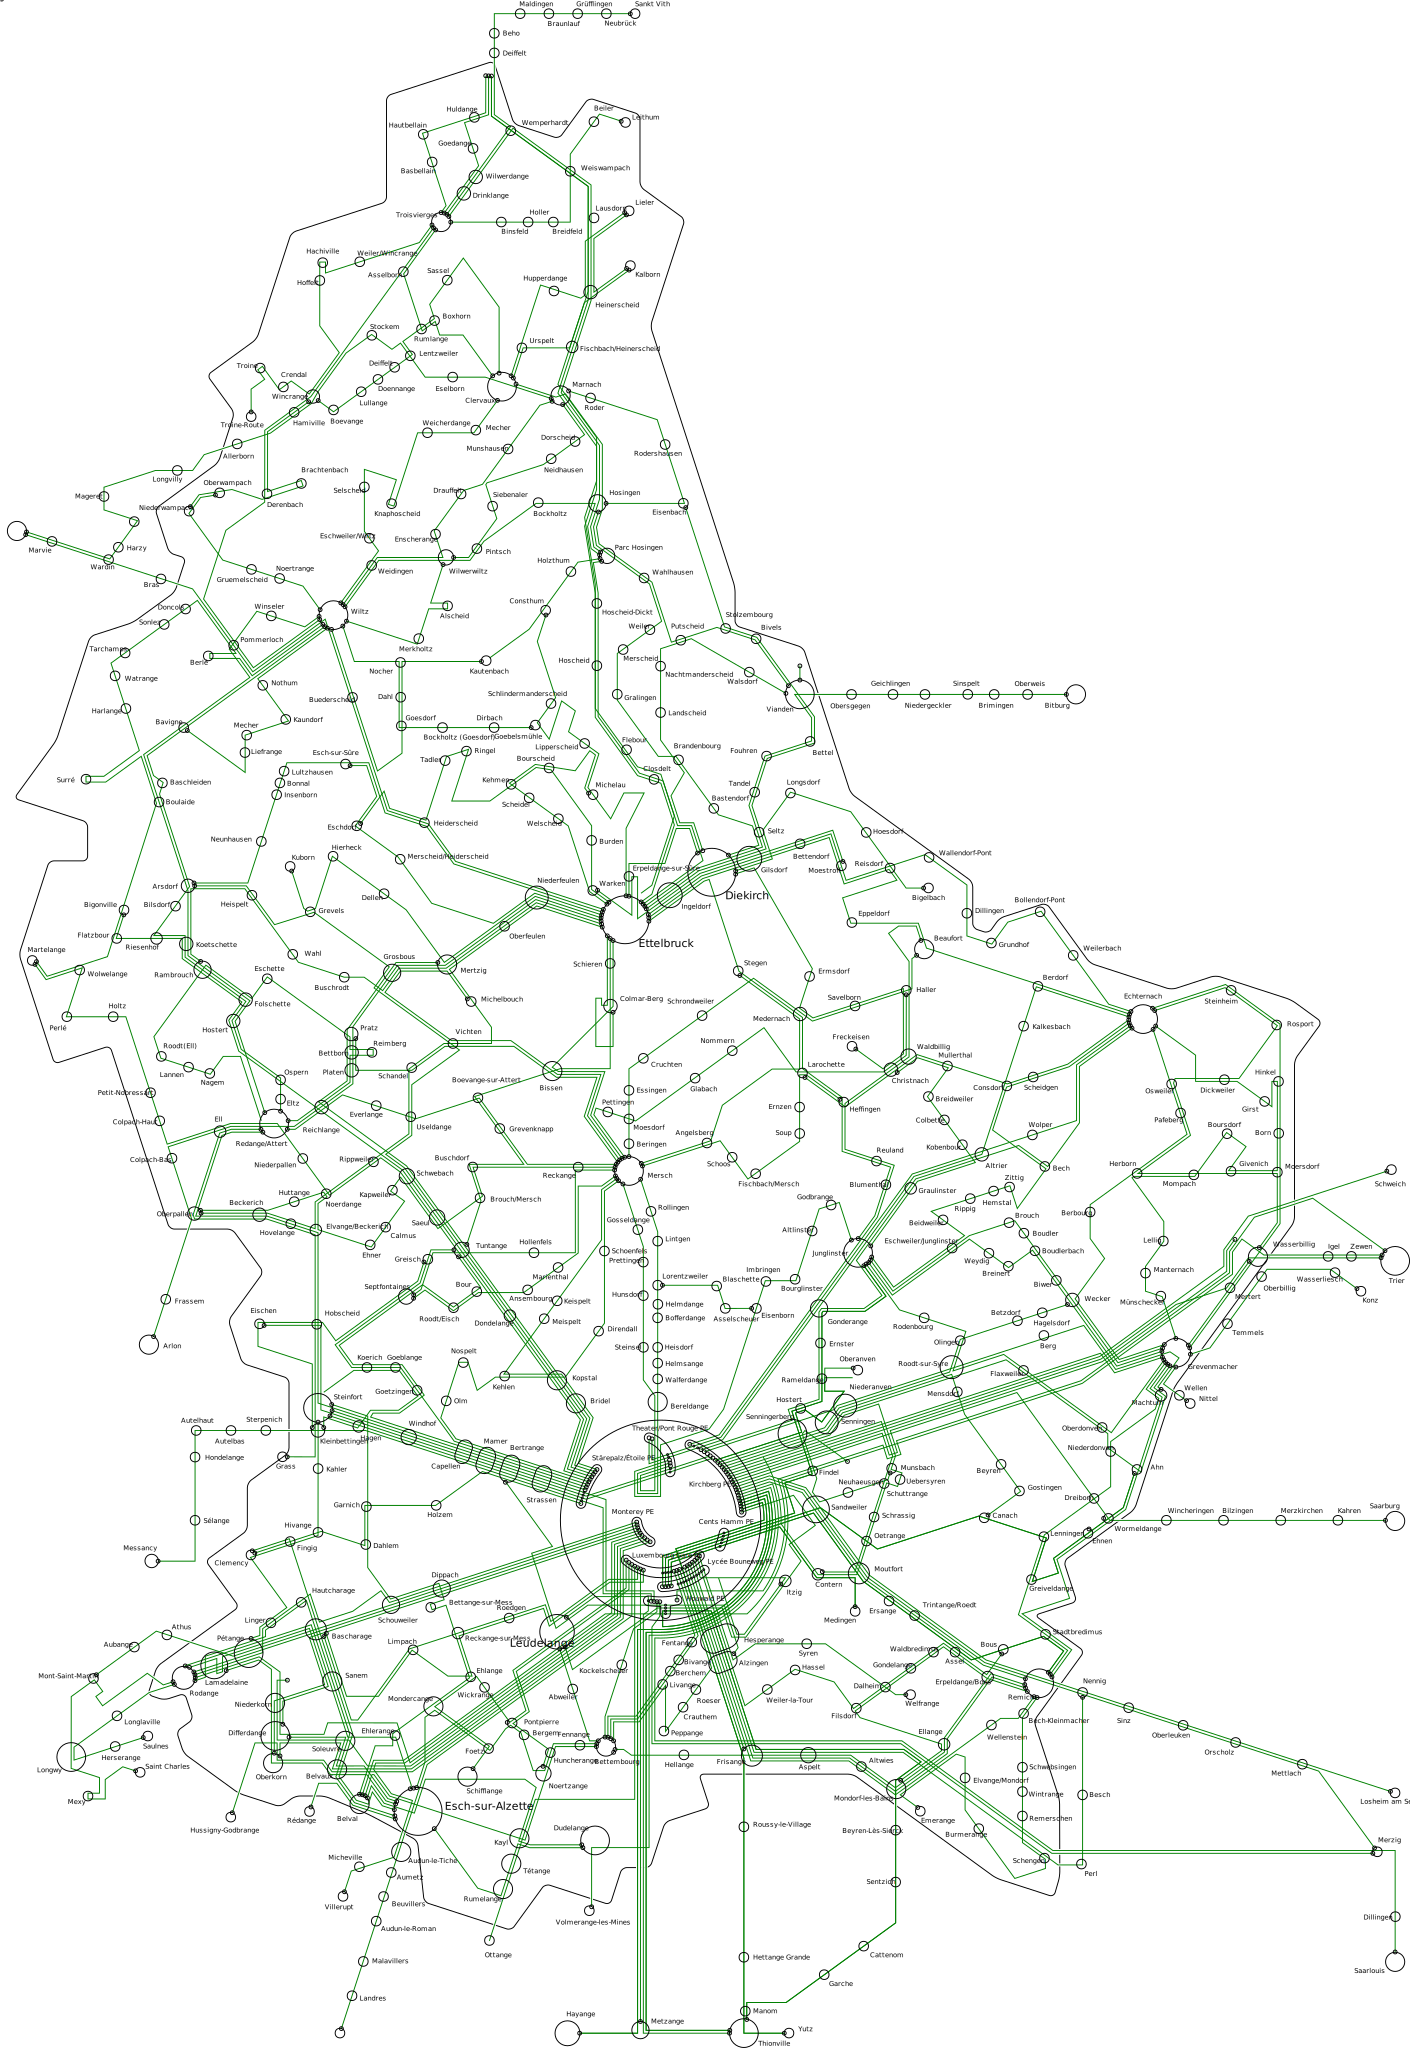

In [14]:
tags = []

def group(*tags, id=None):
    tags = '\n'.join(tags)
    if id:
        return f'<g id="{id}">{tags}</g>'
    return f'<g>{tags}</g>'

def path(d, stroke='black', strokeWidth=1):
    return f'<path d="{d}" style="fill: none; stroke: {stroke}; stroke-width: {strokeWidth}" />'

def ellipse(cx, cy, rx=1, ry=None, stroke='black', fill='none', rotate=0):
    if ry is not None and np.isfinite(ry):
        return f'<ellipse cx="{cx}" cy="{cy}" rx="{rx}" ry="{ry}" style="fill: {fill}; stroke: {stroke};" transform="rotate({rotate})" />'
    return f'<circle cx="{cx}" cy="{cy}" r="{rx}" style="fill: {fill}; stroke: {stroke};" />'

def text(x, y, text, fontSize=8):
    return f'<text x="{x}" y="{y}" style="font-size: 8pt; font-family: sans-serif; font-size: {fontSize};">{text}</text>'

# frontier
tags.append(group(path(frontier['path'].iloc[0]), id='frontier'))

# lines
for kw in ({'stroke': 'white', 'strokeWidth': 3}, {'stroke': 'green', 'strokeWidth': 1}):
    l = (group(path(line.path, **kw), id=f'line-{line.id}') for line in lines.itertuples(index=None))
    tags.append(group(*l, id='lines'))

# stops
s = (group(ellipse(s.cx, s.cy, s.rx) if not pd.isnull(s.rx) else path(s.path)) for s in stops.itertuples())
tags.append(group(*s, id='stops'))

s = (group(text(s.label_x, s.label_y, s.label, fontSize=7 * 1.618 if not pd.isnull(s.rx) and s.rx > 15 else 7)) for s in stops.itertuples())
tags.append(group(*s, id='stop_labels'))

# stations
s = (group(ellipse(s.cx, s.cy, s.rx)) for s in stations.itertuples())
tags.append(group(*s, id='stations'))


svg = '<?xml version="1.0" encoding="UTF-8"?><svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="{}">{}</svg>'
svg = svg.format(viewBox, '\n'.join(tags))

SVG(svg)

There remain a few small problems:

 [ ] the paths for stops in Mamer, Bertrange etc. should be absolute coordinates, not relative
 [ ] there are a couple of ellipses, which require translate / rotate
 [ ] there is the weird --Igel code
 [ ] there is the mistery stop in Germany

Create JSON export files

In [15]:
def optional(**kwargs):
    return {k: v for k, v in kwargs.items() if not pd.isnull(v)}

export = {
    'viewBox': viewBox,
    'frontier': frontier['d'].iloc[0],
    'lines': [
        {'id': group, 'd': d}
        for group, d in (
            lines.groupby('id')
            .agg({'path': list})
            .itertuples(name=None, index=True)
        )
    ], 'stops': [
       optional(id=s.id, label=s.label, cx=s.cx, cy=s.cy, r=s.rx, path=s.path, lx=s.label_x, ly=s.label_y)
       for s in stops.itertuples()
    ], 'stations': [
       optional(id=s.id, cx=s.cx, cy=s.cy, r=s.rx)
       for s in stations.itertuples()   
    ]
}
with open('busmap.json', 'w') as f:
    json.dump(export, f)
shutil.copyfile('busmap.json', '../../public/data/publictransport/busmap.json')

'../../public/data/publictransport/busmap.json'

### Exports for data pre-processing

In [18]:
stops[['id', 'label']].to_csv('stop-places.csv', index=None)